In [ ]:
import torch
import numpy as np
import pandas as pd

In [ ]:
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from sklearn.metrics import confusion_matrix

In [ ]:
%matplotlib inline

# MNIST Image --> Tensors

In [ ]:
!rm -rf /content/Data/MNIST

In [ ]:
transform = transforms.ToTensor()

In [ ]:
train_data = datasets.MNIST(root='/content/Data/train', train=True, download=True, transform=transform)

In [ ]:
test_data = datasets.MNIST(root='/content/Data/test', train=False, download=True, transform=transform)

In [ ]:
type(train_data)

train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
image, label = train_data[0]

In [ ]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
label

5

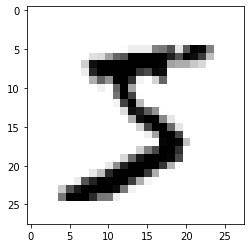

In [ ]:
plt.imshow(image.reshape((28,28)), cmap="gist_yarg")

In [ ]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(train_data, batch_size=500, shuffle=False)

In [ ]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))   # Format

In [ ]:
# First Batch

for images, labels in train_loader:
    break

In [ ]:
images.shape

torch.Size([100, 1, 28, 28])

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


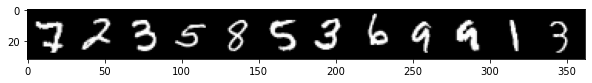

In [ ]:
print('Labels: ', labels[:12].numpy())

im = make_grid(images[:12], nrow=12)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [ ]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# ANN --> CNN
# 105,214 total parameters
for param in model.parameters():
  print(param.numel())

94080
120
10080
84
840
10


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
images.shape  # ---> [100, 784]

torch.Size([100, 1, 28, 28])

In [ ]:
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([100, 1, 28, 28])


In [ ]:
images.view(100, -1).shape

torch.Size([100, 784])

In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.29955012 accuracy:  82.655%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.27259001 accuracy:  87.248%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.18150850 accuracy:  89.318%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.17044601 accuracy:  94.610%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.05073735 accuracy:  95.010%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.14283663 accuracy:  95.250%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.16924375 accuracy:  96.525%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.17162229 accuracy:  96.500%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.10772718 accuracy:  96.580%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.14574622 accuracy:  97.445%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.01242040 accuracy:  97.505%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.07516333 accuracy:  97.418%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.05358853 accuracy:  98.045%
epoch:  4  batch:  400 [ 

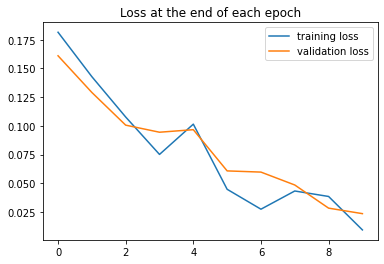

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

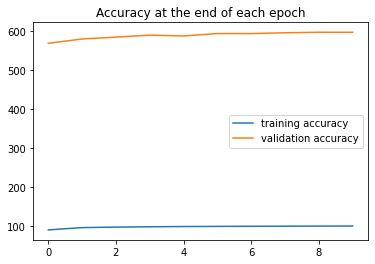

In [ ]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [ ]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(56802), tensor(57907), tensor(58393), tensor(58890), tensor(58687), tensor(59306), tensor(59295), tensor(59503), tensor(59638), tensor(59632)]

Test accuracy: 596.320%


In [ ]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[  46    0    0    0    0    0    0    0    0    0]
 [   0   54    0    0    0    0    0    0    0    0]
 [   0    0   52    0    0    0    0    0    0    0]
 [   0    0    0   48    0    0    0    0    0    0]
 [   0    0    0    0   50    0    0    0    0    0]
 [   0    0    0    0    0   42    0    0    0    0]
 [   0    0    0    0    0    2   55    0    0    0]
 [   0    0    0    0    1    0    0   55    0    0]
 [   0    0    0    0    0    0    0    0   46    0]
 [   0    0    0    0    0    0    0    0    0   49]]


In [ ]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

3

In [ ]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [ 201  231  415]
Label: [   5    5    4]
Guess: [   6    6    7]


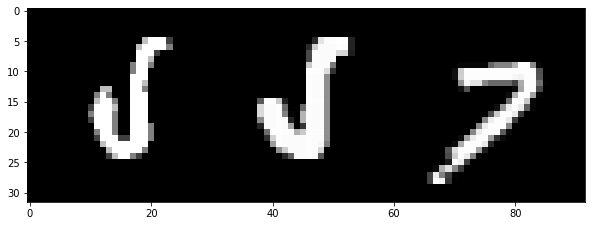

In [ ]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));